## Ibrahim AbuAlhaol, Ottawa, Canada, DEC 10, 2017 

* Q1: Using data in Bar.csv, How much faster does the treatment improves the dom time?
    - <b>Methodology:</b> A/B t-statistic test or ANOVA test to prove statistica significance 
    - <b>Results: </b>  On average, the treatment improves the dom time by 1.78  (21.08 -19.30)
* Q2: Using data in Foo.csv, How much faster is H2 over H1? What percent improvement does H2 offer? 
    - <b>Methodology:</b> A/B t-statistic test or ANOVA test to prove statistical significance 
    - <b>Results: </b> No real difference (i.e.,significance) and therfore we can not conclude which one is faster 
* Q3: Any other interesting things that jump out from the data? 
    - <b>Methodology:</b> Pearson Correlation, Anova testing, and principal component analysis (PCA).   
    - <b>Results: BAR.CSV data </b> 
         - 'host', 'queryString', 'browser', 'isp', 'page' are related with statistical significance with the dom time 
         - 'dom'  and 'f1','f2','f3' ....,'f9' are not correlated with each other 
         - 'device' is not correlated with the 'dom' time 
         
    - <b>Results: FOO.CSV data </b> 
         - 'loadTime' is correlated (relatively) with most of the numerical features except 'run_no' and 'requests' as shown below 
         - 'requests' is related to 'label' and 'location' with high F-statistics 
         -  Many of the numerical features explain most of the variance in the 'loadTime' which is very expected but we here show that by statistical analysis



### Importing Libraries 

In [4]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style("darkgrid")
import numpy as np
import statsmodels.formula.api as smf
from scipy import stats
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

### Functions 

In [5]:

    
def VioPlot(Col1,Col2,Title='',size=10):
    fig, ax = plt.subplots(figsize=(size, size))
    sns.violinplot(x=Col1, y=Col2, showmeans=True,scale="width", inner="quartile")
    plt.title(Title)
    plt.show()
   

    

def Hist_Plot(A,B, x_label='x',legends=['',''],size=10):
    xweights = 100 * np.ones_like(A) / len(A)
    yweights = 100 * np.ones_like(B) / len(B)
    fig, ax = plt.subplots(figsize=(size, size))
    ax.hist(A, weights=xweights, color='lightblue', alpha=0.9, bins=50)
    ax.hist(B, weights=yweights, color='salmon', alpha=0.3,bins=50)
    ax.legend(legends)
    ax.set(title='Histogram Comparison', ylabel='% of Dataset in Bin')
    ax.margins(0.05)
    ax.set_ylim(bottom=0)
    plt.xlabel(x_label)
    plt.show()
    
def plot_corr(df):
    f, ax = plt.subplots(figsize=(15, 12))
    corr = df.corr()
    sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),square=True, ax=ax)
    plt.show()

### Importing the CSV files 

In [6]:
BAR=pd.read_csv('data/bar.csv')
FOO=pd.read_csv('data/foo.csv')
DF_trtmt_dom=BAR[['trtmt','dom']]
DF_FOO=FOO[['label','loadTime','fullyLoaded']]

# Q1: 
# -------

In [7]:
BAR.head(3)

,Unnamed: 0,host,page,isp,browser,device,trtmt,dom,queryString,f1,f2,f3,f4,f5,f6,f7,f8,f9
0,1,host_4,page_1,isp_2,browser_1,device_1,On,43.846811,Off,0.205366,0.817999,0.533166,0.358433,0.069712,0.370256,0.248647,0.562306,0.387616
1,2,host_2,page_3,isp_4,browser_3,device_1,On,34.078843,Off,0.455522,0.793443,0.090781,0.609515,0.746002,0.511265,0.664359,0.240108,0.696536
2,3,host_1,page_1,isp_1,browser_1,device_1,On,10.423054,On,0.195735,0.491308,0.147366,0.797300,0.409352,0.857075,0.198729,0.850010,0.658896


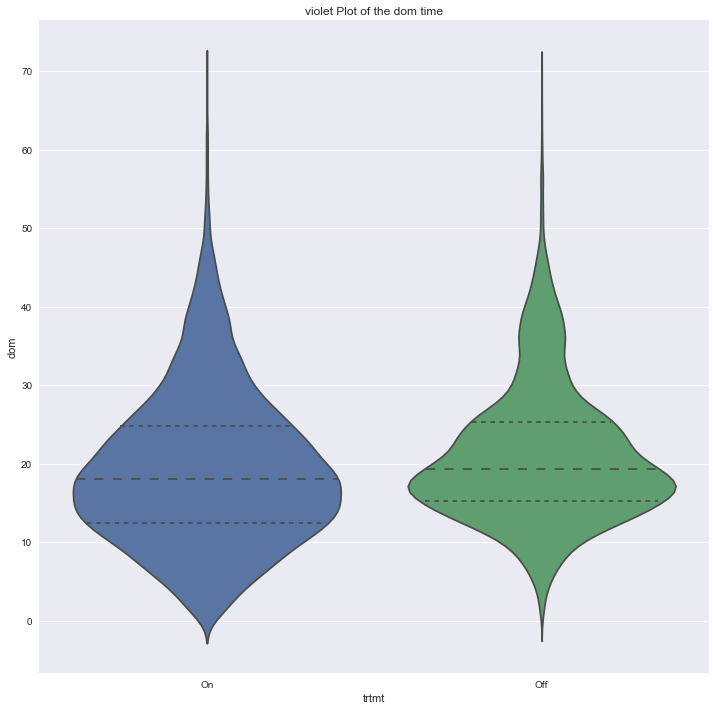

In [8]:
VioPlot(BAR['trtmt'], BAR['dom'],'violet Plot of the dom time',12)

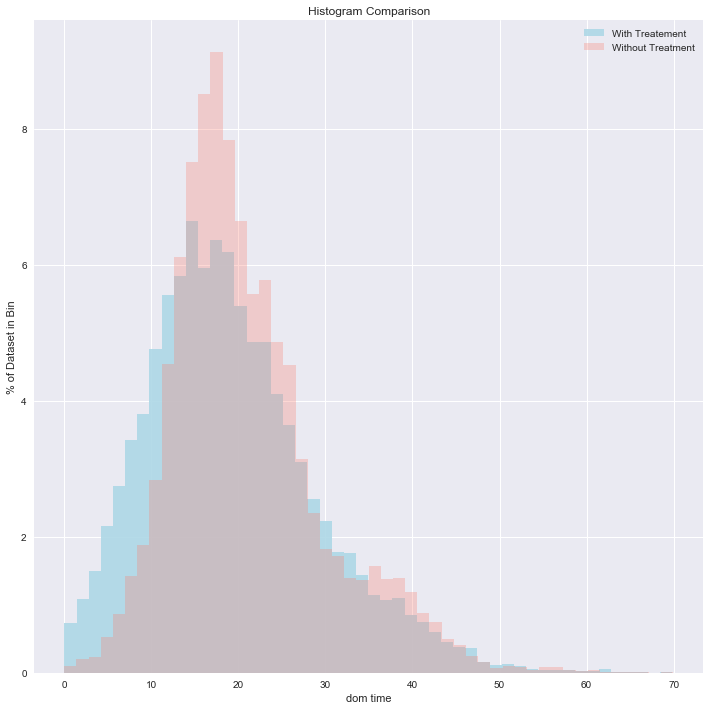

In [9]:
A=DF_trtmt_dom[DF_trtmt_dom['trtmt']=='On']['dom'].tolist()
B=DF_trtmt_dom[DF_trtmt_dom['trtmt']=='Off']['dom'].tolist()
Hist_Plot(A,B,'dom time',['With Treatement', 'Without Treatment'],size=12)


In [42]:
DOM_TRM_ON_Mean=DF_trtmt_dom[DF_trtmt_dom['trtmt']=='On']['dom'].mean()
DOM_TRM_OFF_Mean=DF_trtmt_dom[DF_trtmt_dom['trtmt']=='Off']['dom'].mean()
print ('\nThe average dom time with treatement = {}'.format(DOM_TRM_ON_Mean) )
print ('The average dom time without treatement = {} \n'.format(DOM_TRM_OFF_Mean) )


The average dom time with treatement = 19.30002315993797
The average dom time without treatement = 21.080772215776854 



* The difference in the dom time aveage does NOT prove the relationship between the treatment and the dom time.
* We now run two tests : (1) A/B t-statistic test, and (2) ANOVA test

>(1) The t-statistic (A/B test) is a measure of the difference between the two sets expressed in units of standard error. To have a real difference ("statistically significant" we need to see very low p-value and a high absolute value of the t-statistic . 


>(2) Anova F-statistic test to identify if the treatment (categorical predictor variable) associated or 
  related with the dom time (quantitative target variable)? to prove the relationship we look for high F-statistic and very low Prob (F-statistic) values.
  
> (3) Baysian A/B Test with confidence 



#### (3) Baysian A/B Test with confidence

In [43]:
%matplotlib inline
import numpy as np 
import pymc3 as pm
import seaborn as sb
from theano import config
config.warn.round=False

with pm.Model() as model: # context management
    # define priors
    prior_A = pm.Uniform('prior_A', lower=np.mean(A)*.5, upper=np.mean(A)*1.5)
    prior_B = pm.Uniform('prior_B', lower=np.mean(B)*.5, upper=np.mean(B)*1.5)

    # define likelihood
    like_A = pm.Normal('like_A', mu=prior_A , sd=np.std(A), observed=A)
    like_B = pm.Normal('like_B', mu=prior_B , sd=np.std(B), observed=B)
    
    # define metrics
    pm.Deterministic('difference', prior_B - prior_A)
    pm.Deterministic('relation', (prior_B/prior_A) - 1)

    # inference
    trace = pm.sample(draws=50000, step=pm.Metropolis(), start=pm.find_MAP(), progressbar=True)

logp = -1.0868e+05, ||grad|| = 2.5163e-12: 100%|██████████| 2/2 [00:00<00:00, 371.06it/s]
100%|██████████| 50500/50500 [00:38<00:00, 1299.58it/s]


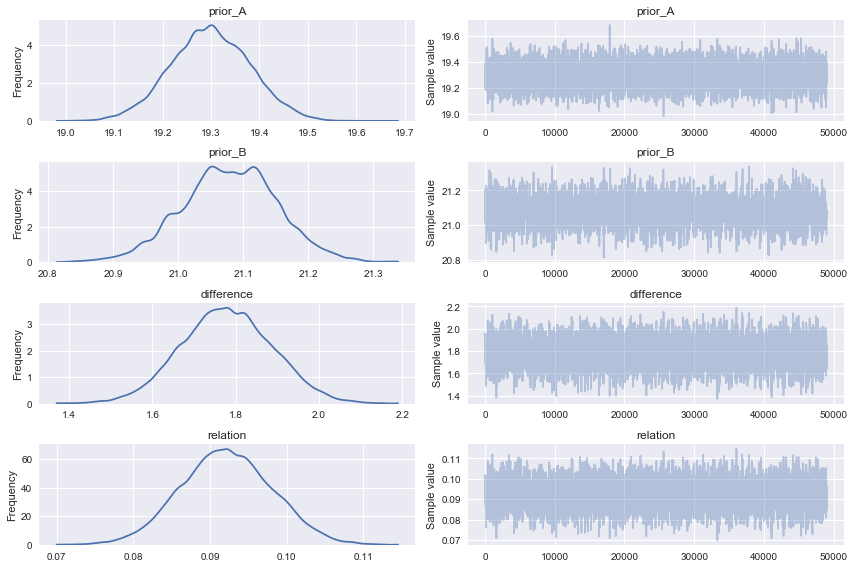

In [44]:
_ = pm.traceplot(trace[1000:], grid=True)


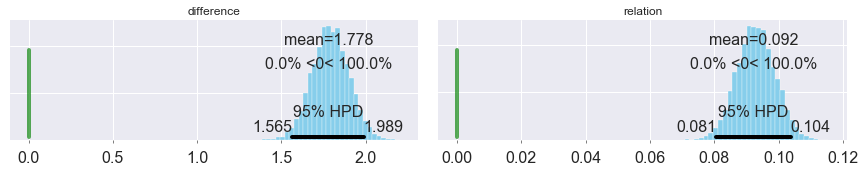

In [45]:
_ = pm.plot_posterior(trace[1000:], varnames=['difference', 'relation'], 
                      ref_val=0, color='#87ceeb')

>> Looking at the difference or relation histogram we see we have __100%__ confidence that B is better than A. If we have earlier defined a significance level of 5%, we can declare that B is a winner. If that was not the case, then, We need to either capture more data or stop the experiment and call it a draw

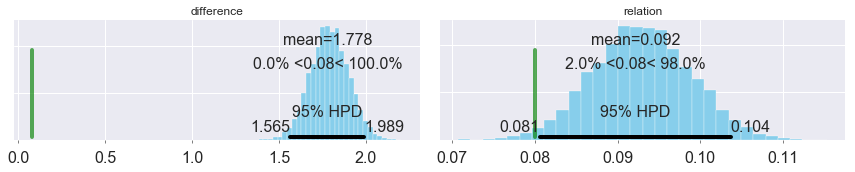

In [46]:
_ = pm.plot_posterior(trace[1000:], varnames=['difference', 'relation'], 
                      ref_val=.08, color='#87ceeb')

>> Looking at the difference or relation histogram we see we have __98.4%__ confidence that B is 8% or more better than A. If we have earlier defined a significance level of 5%, we can declare that B is a winner. If that was not the case, then, We need to either capture more data or stop the experiment and call it a draw

In [47]:
print (" Using mean only B is better A by {0:0.2f} %".format(100*(np.mean(B)/np.mean(A)-1)))

 Using mean only B is better A by 9.23 %


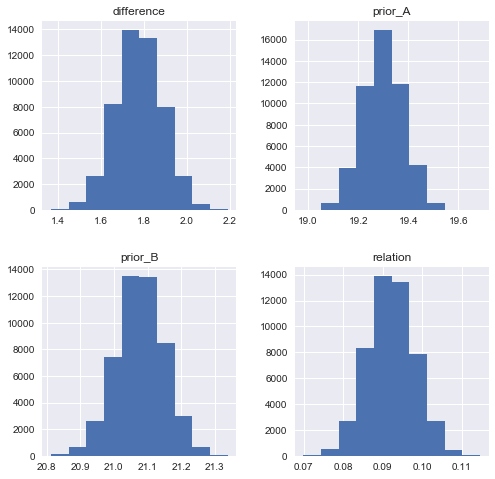

In [48]:
DF=pm.trace_to_dataframe(trace)
DF.hist(figsize=(8,8))
plt.show()

#### (1) A/B t-statistic test

In [8]:
A=DF_trtmt_dom[DF_trtmt_dom['trtmt']=='On']['dom'].tolist()
B=DF_trtmt_dom[DF_trtmt_dom['trtmt']=='Off']['dom'].tolist()
stats.ttest_ind(A, B)

Ttest_indResult(statistic=-16.498032027469961, pvalue=7.063553955755318e-61)

- Hight absolute t-statistic =16.49  and low p-value=7e-61 

#### (2) Anova F-statistic test 

In [9]:
model = smf.ols(formula='dom ~ trtmt', data=BAR)
results = model.fit()
FValue=results.fvalue
FProp=results.f_pvalue 
R_sqr=results.rsquared
print ('\nF-statistic = {}'.format(FValue))
print ('Prob (F-statistic) = {}'.format(FProp))
#print (results.summary())


F-statistic = 272.1850607794322
Prob (F-statistic) = 7.063553955518299e-61


- Hight F-statistic = 272.18  and low p-value=7e-61 

* Given that the absolute t-statistics is high with very low p-value in the A/B test and/or the F-statistic is very large and the Prob (F-statistic) is very small in ANOVA test, then, we can say that the change in dom time is related to the treatement but with

> On average, the treatment improves the dom time by 1.78  (21.08 -19.30)


* ------------------------------------------------------------------------------------------

# Q2: 
# -------


In [10]:
FOO.head(3)

,testId,label,location,completed_time_stamp,completed_time,run_no,loadTime,fullyLoaded,bytesIn,bytesInDoc,requests,requestsDoc,TTFB,firstPaint,render,SpeedIndex,docTime,ttfb_first_req,ssl_first_req,dns_first_req
0,171108_EG_BX,h1,WPTServer100:Chrome,1510215941,2017-11-09_03-25-41,1,15902,15902,634911,0,86,0,7497,0,15800,15885,0,7260,104,0
1,171108_60_6B,h1,WPTServer102:Chrome,1510172803,2017-11-08_15-26-43,8,45054,46018,929154,927960,97,95,1511,43801,43800,44497,45054,1284,111,0
2,171108_60_6B,h1,WPTServer102:Chrome,1510172803,2017-11-08_15-26-43,18,25006,25094,963762,962612,98,97,1010,2680,2700,11964,25006,766,119,0


In [11]:
Diff=DF_FOO.apply(lambda row: row[2]-row[1],axis=1)

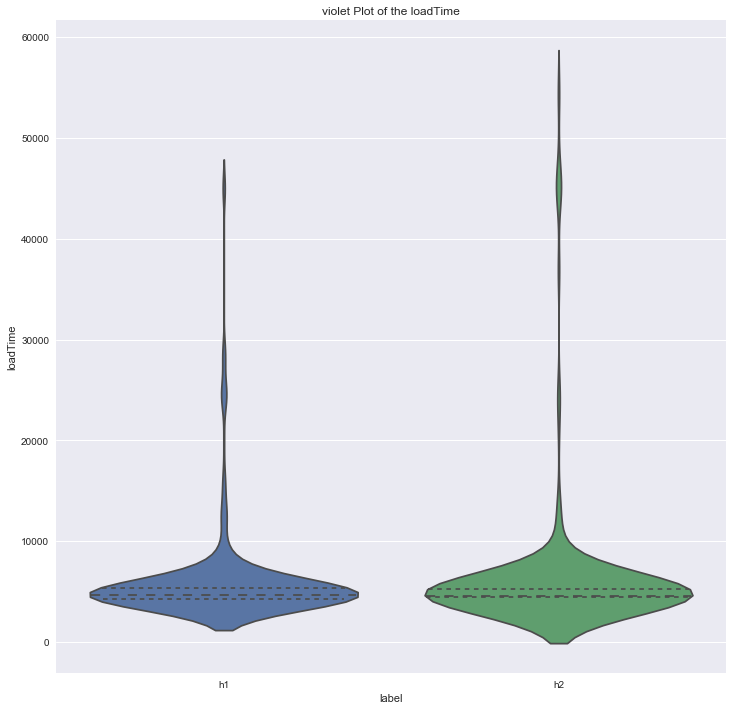

In [12]:
VioPlot(DF_FOO['label'], DF_FOO['loadTime'],'violet Plot of the loadTime',12)

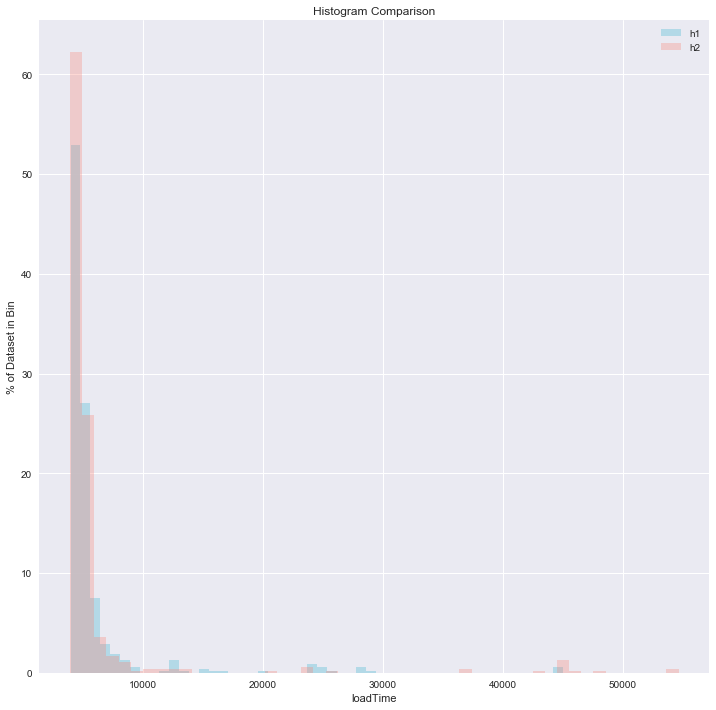

In [49]:
A=DF_FOO[DF_FOO['label']=='h1']['loadTime'].tolist()
B=DF_FOO[DF_FOO['label']=='h2']['loadTime'].tolist()
Hist_Plot(A,B,'loadTime',legends=['h1','h2'],size=12)


In [50]:
print ('\nThe average loadTime in h1 = {}'.format(np.mean(A)))
print ('The average dom loadTime in h2 = {} \n'.format(np.mean(B)) )


The average loadTime in h1 = 5964.520833333333
The average dom loadTime in h2 = 6302.229166666667 



In [51]:
%matplotlib inline
import numpy as np 
import pymc3 as pm
import seaborn as sb
from theano import config
config.warn.round=False

with pm.Model() as model: # context management
    # define priors
    prior_A = pm.Uniform('prior_A', lower=np.mean(A)*.5, upper=np.mean(A)*1.5)
    prior_B = pm.Uniform('prior_B', lower=np.mean(B)*.5, upper=np.mean(B)*1.5)

    # define likelihood
    like_A = pm.Normal('like_A', mu=prior_A , sd=np.std(A), observed=A)
    like_B = pm.Normal('like_B', mu=prior_B , sd=np.std(B), observed=B)
    
    # define metrics
    pm.Deterministic('difference', prior_B - prior_A)
    pm.Deterministic('relation', (prior_B/prior_A) - 1)

    # inference
    trace = pm.sample(draws=50000, step=pm.Metropolis(), start=pm.find_MAP(), progressbar=True)

logp = -9,697, ||grad|| = 6.6777e-14: 100%|██████████| 2/2 [00:00<00:00, 350.94it/s]
100%|██████████| 50500/50500 [00:22<00:00, 2249.00it/s]


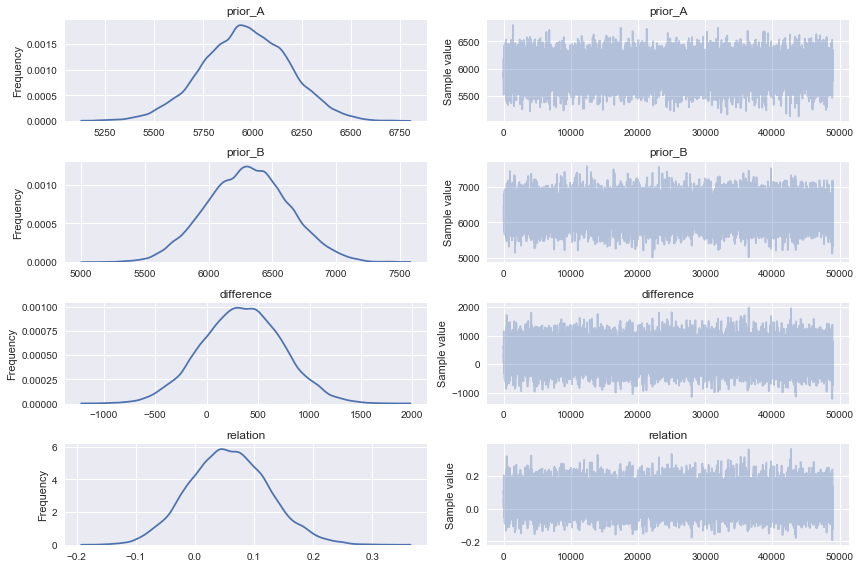

In [52]:
_ = pm.traceplot(trace[1000:], grid=True)


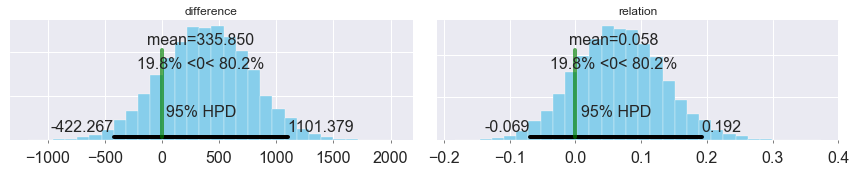

In [53]:
_ = pm.plot_posterior(trace[1000:], varnames=['difference', 'relation'], 
                      ref_val=0, color='#87ceeb')

>> Looking at the difference or relation histogram we see we have __80.2%__ confidence that __B__ is better than __A__. If we have earlier defined a significance level of 95%, we can not declare that B is a winner. We need to either capture more data or stop the experiment and call it a draw

In [62]:
print("\n \n Using mean only B is better A by {0:0.2f} % \n \n Which is not correct".format(100*(np.mean(B)/np.mean(A)-1)))


 
 Using mean only B is better A by 5.66 % 
 
 Which is not correct


***

* The difference in the loadTime aveage does NOT prove the relationship with label (h1 or h2) 
* We now run two tests : (1) A/B t-statistic test, and (2) ANOVA test

>(1) The t-statistic (A/B test) . 


>(2) Anova F-statistic test

>(3) AB Baysian Inference with MCMC simulation 





#### (1) A/B t-statistic test

In [15]:
stats.ttest_ind(A, B)

Ttest_indResult(statistic=-0.8736228043200106, pvalue=0.3825426361512243)

- Low absolute t-statistic = 0.873  and high p-value=0.38

#### (2) Anova F-statistic test 

In [16]:
model = smf.ols(formula='loadTime ~ label', data=DF_FOO)
results = model.fit()
FValue=results.fvalue
FProp=results.f_pvalue 
R_sqr=results.rsquared
print ('\nF-statistic = {}'.format(FValue))
print ('Prob (F-statistic) = {}'.format(FProp))
#print (results.summary())


F-statistic = 0.7632168042276727
Prob (F-statistic) = 0.3825426361510831


- Low F-statistic = 0.763 and High p-value = 0.382 

* Given that the absolute t-statistics is low with very high p-value in the A/B test and/or the F-statistic is very low and the Prob (F-statistic) is very high in ANOVA test, then


> No real difference (i.e., no statistical significance) and therfore we can not conclude which one is faster 


# Q3: 
# -------


In [17]:
# Pearson Correlation


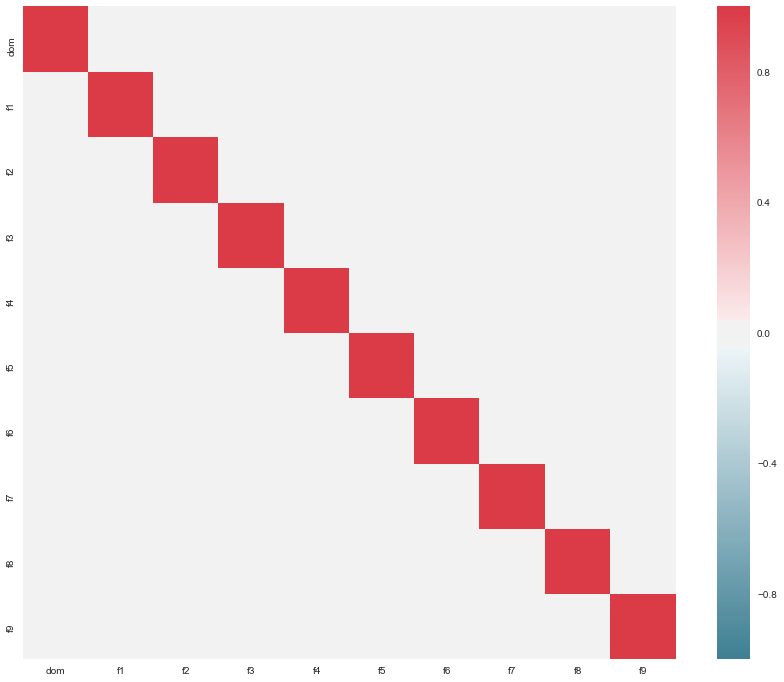

In [18]:
BAR=BAR[BAR.columns[1:]]
plot_corr(BAR)

In [19]:
BAR.corr()

,dom,f1,f2,f3,f4,f5,f6,f7,f8,f9
dom,1.000000,-0.004268,-0.009095,0.006870,-0.002335,-0.007035,0.000647,0.001945,0.007762,-0.000939
f1,-0.004268,1.000000,0.001720,-0.004882,-0.005273,-0.001245,0.005581,0.002995,0.005796,0.004510
f2,-0.009095,0.001720,1.000000,0.001018,-0.001906,-0.005101,0.002350,0.003597,0.000874,0.003751
f3,0.006870,-0.004882,0.001018,1.000000,-0.002628,-0.004128,-0.012043,0.010262,-0.007281,0.000404
f4,-0.002335,-0.005273,-0.001906,-0.002628,1.000000,0.000314,-0.002523,-0.008377,0.002205,0.001908
f5,-0.007035,-0.001245,-0.005101,-0.004128,0.000314,1.000000,-0.008828,-0.009184,0.005812,-0.000252
f6,0.000647,0.005581,0.002350,-0.012043,-0.002523,-0.008828,1.000000,-0.001538,0.003601,0.001398
f7,0.001945,0.002995,0.003597,0.010262,-0.008377,-0.009184,-0.001538,1.000000,0.006083,-0.000910
f8,0.007762,0.005796,0.000874,-0.007281,0.002205,0.005812,0.003601,0.006083,1.000000,-0.009387
f9,-0.000939,0.004510,0.003751,0.000404,0.001908,-0.000252,0.001398,-0.000910,-0.009387,1.000000


From the correlation matrix above 
> dom time and f1,f2,f3 ....,f9 are not correlated with each other 



In [20]:
def plot_feature_class_mean(DF,features,label,En_plot=False):
    ANOVA_DF=pd.DataFrame(index=list(features),columns=['F_value','F_prop','R_sqr','R_sqr_ajd'])
    for feature in features:
        if En_plot==True:
            sns.boxplot(x=DF[label], y=DF[feature], showmeans=True)
            plt.grid()
            plt.show()
        #ANOVA F Test
        model = smf.ols(formula=str(feature)+' ~ '+str(label), data=DF)
        results = model.fit()
        F_Prop=results.f_pvalue
        F_value=results.fvalue
        R_sqr=results.rsquared
        R_adj_sqr=results.rsquared_adj
        ANOVA_DF.loc[feature]=[F_value,F_Prop,R_sqr,R_adj_sqr]
    return  ANOVA_DF

In [21]:
BAR.head(3)

,host,page,isp,browser,device,trtmt,dom,queryString,f1,f2,f3,f4,f5,f6,f7,f8,f9
0,host_4,page_1,isp_2,browser_1,device_1,On,43.846811,Off,0.205366,0.817999,0.533166,0.358433,0.069712,0.370256,0.248647,0.562306,0.387616
1,host_2,page_3,isp_4,browser_3,device_1,On,34.078843,Off,0.455522,0.793443,0.090781,0.609515,0.746002,0.511265,0.664359,0.240108,0.696536
2,host_1,page_1,isp_1,browser_1,device_1,On,10.423054,On,0.195735,0.491308,0.147366,0.797300,0.409352,0.857075,0.198729,0.850010,0.658896


# Applying ANOVA test for all categorical variables
- 'host',
- 'page',
- 'isp',
- 'browser',
- 'device',
- 'queryString'

In [22]:
Features=BAR.columns[[6,8,9,10,11,12,13,14,15,16]]
Labels=['host','page','isp','browser','device','queryString']
for lab in Labels:
    ANOVA_DF=plot_feature_class_mean(BAR,Features,lab, False)
    print('\n=====================ANOVA with {}====================='.format (lab))
    print(ANOVA_DF)

print ("=======================================================")



=====================ANOVA with host=====================
      F_value    F_prop        R_sqr    R_sqr_ajd
dom   1575.54         0     0.442476     0.442195
f1   0.513991  0.934862  0.000258844 -0.000244753
f2   0.752182  0.732283  0.000378751 -0.000124786
f3    1.47455  0.104828  0.000742219  0.000238866
f4   0.491761  0.946328  0.000247652  -0.00025595
f5   0.599168  0.878138  0.000301726 -0.000201849
f6   0.831914  0.642484  0.000418882 -8.46341e-05
f7   0.712825  0.774053   0.00035894 -0.000144606
f8   0.927349  0.532364  0.000466913 -3.65791e-05
f9   0.956264  0.499643  0.000481465 -2.20204e-05

=====================ANOVA with page=====================
      F_value        F_prop        R_sqr    R_sqr_ajd
dom   52.9434  1.70713e-167     0.027661    0.0271386
f1    1.91253     0.0151639    0.0010266  0.000489825
f2    1.00188      0.450897   0.00053805  1.01173e-06
f3   0.739241      0.755714  0.000397057 -0.000140058
f4    1.02456      0.425937  0.000550219  1.31874e-05
f5    1.

### From the above results on BAR.csv data: 
* host, queryString, browser, isp, page are related with statistical significance with the dom time 
* device is not correlated with the dom time 

    

 -------------------- ----------------------------------------------------------------------------------------------------

In [23]:
FOO.head(3)

,testId,label,location,completed_time_stamp,completed_time,run_no,loadTime,fullyLoaded,bytesIn,bytesInDoc,requests,requestsDoc,TTFB,firstPaint,render,SpeedIndex,docTime,ttfb_first_req,ssl_first_req,dns_first_req
0,171108_EG_BX,h1,WPTServer100:Chrome,1510215941,2017-11-09_03-25-41,1,15902,15902,634911,0,86,0,7497,0,15800,15885,0,7260,104,0
1,171108_60_6B,h1,WPTServer102:Chrome,1510172803,2017-11-08_15-26-43,8,45054,46018,929154,927960,97,95,1511,43801,43800,44497,45054,1284,111,0
2,171108_60_6B,h1,WPTServer102:Chrome,1510172803,2017-11-08_15-26-43,18,25006,25094,963762,962612,98,97,1010,2680,2700,11964,25006,766,119,0


## Pearson correlation

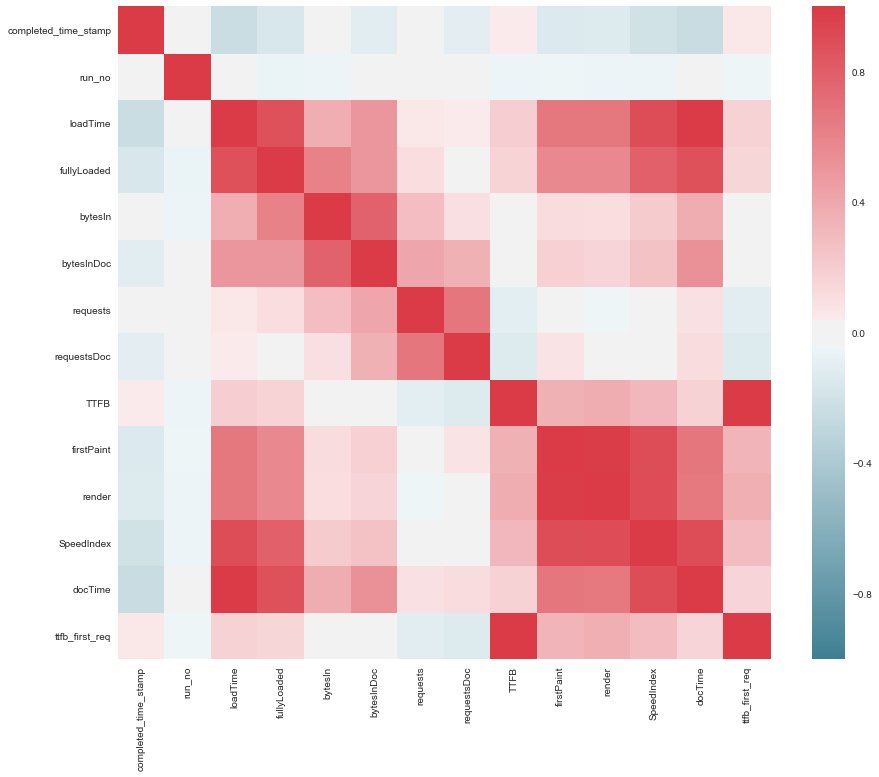

In [24]:
plot_corr(FOO[FOO.columns[0:-2]])

In [25]:
FOO[FOO.columns[0:-2]].corr()

,completed_time_stamp,run_no,loadTime,fullyLoaded,bytesIn,bytesInDoc,requests,requestsDoc,TTFB,firstPaint,render,SpeedIndex,docTime,ttfb_first_req
completed_time_stamp,1.000000,0.000000,-0.240292,-0.159038,0.007876,-0.115974,-0.024836,-0.098903,0.045251,-0.138790,-0.131219,-0.198930,-0.246716,0.061173
run_no,0.000000,1.000000,-0.035689,-0.058041,-0.048068,-0.020020,-0.025821,-0.020400,-0.051665,-0.040207,-0.048601,-0.050843,-0.033875,-0.045520
loadTime,-0.240292,-0.035689,1.000000,0.881473,0.369946,0.503299,0.058097,0.040161,0.197234,0.668293,0.671666,0.896433,0.995147,0.176893
fullyLoaded,-0.159038,-0.058041,0.881473,1.000000,0.604159,0.504099,0.111647,0.008707,0.170064,0.573242,0.573612,0.791800,0.879433,0.151765
bytesIn,0.007876,-0.048068,0.369946,0.604159,1.000000,0.775295,0.284910,0.102962,0.003180,0.123573,0.112788,0.209017,0.378366,-0.007088
bytesInDoc,-0.115974,-0.020020,0.503299,0.504099,0.775295,1.000000,0.409192,0.355629,-0.018947,0.186304,0.161425,0.259374,0.526058,-0.030090
requests,-0.024836,-0.025821,0.058097,0.111647,0.284910,0.409192,1.000000,0.675690,-0.109034,-0.005223,-0.043265,-0.003971,0.097730,-0.110680
requestsDoc,-0.098903,-0.020400,0.040161,0.008707,0.102962,0.355629,0.675690,1.000000,-0.129877,0.084457,-0.001533,0.028308,0.123664,-0.131912
TTFB,0.045251,-0.051665,0.197234,0.170064,0.003180,-0.018947,-0.109034,-0.129877,1.000000,0.354198,0.382612,0.317905,0.179630,0.995724
firstPaint,-0.138790,-0.040207,0.668293,0.573242,0.123573,0.186304,-0.005223,0.084457,0.354198,1.000000,0.987407,0.894932,0.673685,0.335440


> ## 'loadTime' is correlated relatively with most of the features except 'run_no' and requests as shown above 

# Applying ANOVA test for all categorical variables

- 'label',
- 'location', 
- 'run_no', 
- 'testId'


In [26]:
Features=FOO.columns[6:-1].tolist()
Labels=['label','location','run_no','testId']
for lab in Labels:
    ANOVA_DF=plot_feature_class_mean(FOO,Features,lab, False)
    print('\n=====================ANOVA with {}====================='.format (lab))
    print(ANOVA_DF)

print ("=======================================================")



=====================ANOVA with label=====================
                  F_value        F_prop        R_sqr    R_sqr_ajd
loadTime         0.763217      0.382543  0.000796043 -0.000246967
fullyLoaded      0.669947      0.413273   0.00069883 -0.000344282
bytesIn             6.866    0.00892416   0.00711601    0.0060796
bytesInDoc        13.6598   0.000231518    0.0140582     0.013029
requests          969.511  1.31985e-147     0.502986     0.502467
requestsDoc       32.6587   1.46616e-08    0.0329666    0.0319572
TTFB              2.96445     0.0854361   0.00308487   0.00204425
firstPaint       0.788031      0.374919  0.000821904  -0.00022108
render            1.11951      0.290291   0.00116723  0.000124604
SpeedIndex      0.0165786      0.897576  1.73051e-05  -0.00102652
docTime          0.793782      0.373183  0.000827897 -0.000215081
ttfb_first_req    2.91333     0.0881745   0.00303183   0.00199116
ssl_first_req     1.42078       0.23357   0.00148087  0.000438579

===============


> #### 'requests' is related to 'label' and 'location' with high F-statistics 

In [27]:
DF_New=FOO[FOO.columns[6:-2]]
DF_New.head(10)

,loadTime,fullyLoaded,bytesIn,bytesInDoc,requests,requestsDoc,TTFB,firstPaint,render,SpeedIndex,docTime,ttfb_first_req
0,15902,15902,634911,0,86,0,7497,0,15800,15885,0,7260
1,45054,46018,929154,927960,97,95,1511,43801,43800,44497,45054,1284
2,25006,25094,963762,962612,98,97,1010,2680,2700,11964,25006,766
3,24283,24352,1006265,1005115,99,98,1432,22778,22700,23424,24283,1216
4,23829,23904,882269,881119,99,98,1005,22335,22300,23013,23829,767
5,44898,45030,950278,949128,99,98,1018,2655,2600,20966,44898,766
6,45051,45165,1090232,1089082,99,98,984,2614,2600,21029,45051,757
7,6081,6602,1041090,1039896,99,97,1029,4469,4500,5185,6081,799
8,4286,4999,951761,950567,99,97,1141,2750,2800,3501,4286,942
9,24662,24740,911578,910428,99,98,1789,23110,23100,23867,24662,755


In [28]:
X = DF_New.iloc[:,1:]
y = DF_New.loadTime
pca = PCA()
X_reduced = pca.fit_transform(scale(X))
PERC=list(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))
FEAT=list(X.columns)
DF_PCA=pd.DataFrame({'Feature':FEAT,'Explained_Variance':PERC})
DF_PCA [['Feature','Explained_Variance']]

,Feature,Explained_Variance
0,fullyLoaded,43.08
1,bytesIn,66.10
2,bytesInDoc,79.37
3,requests,90.61
4,requestsDoc,94.34
5,TTFB,97.53
6,firstPaint,99.45
7,render,99.80
8,SpeedIndex,99.93
9,docTime,99.97


> #### Many of the Feature explain most of the variance in the 'loadTime' which is very expected but we here show that by statistical analysis 


Thanks, I enjoyed working on this task. I tried my best to not use any domain knowledge and use math/statistics to land on the conclusions.
    
-Ibrahim